In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

ERROR! Session/line number was not unique in database. History logging moved to new session 553


In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [5]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [6]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


In [8]:
x_train_3d= np.log(x_train)
x_val_3d= np.log(x_val)
x_test_3d= np.log(x_test)
y_train_3d = np.log(y_train)
y_val_3d= np.log(y_val)
y_test_3d=np.log(y_test)

/tmp/ipykernel_888557/3758705373.py:1: RuntimeWarning: divide by zero encountered in log
  x_train_3d= np.log(x_train)
/tmp/ipykernel_888557/3758705373.py:2: RuntimeWarning: divide by zero encountered in log
  x_val_3d= np.log(x_val)
/tmp/ipykernel_888557/3758705373.py:3: RuntimeWarning: divide by zero encountered in log
  x_test_3d= np.log(x_test)
/tmp/ipykernel_888557/3758705373.py:4: RuntimeWarning: divide by zero encountered in log
  y_train_3d = np.log(y_train)
/tmp/ipykernel_888557/3758705373.py:5: RuntimeWarning: divide by zero encountered in log
  y_val_3d= np.log(y_val)
/tmp/ipykernel_888557/3758705373.py:6: RuntimeWarning: divide by zero encountered in log
  y_test_3d=np.log(y_test)


In [9]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            buffer_scale=1.01):
    """
    Projects all input and output 3D densities to 2D RGB with shared normalization.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        buffer_scale: float, buffer for normalization (default 10%)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    # Convert all to RGB (unnormalized)
    x_train_rgb = split_sum_rgb(x_train_3d)
    x_val_rgb   = split_sum_rgb(x_val_3d)
    x_test_rgb  = split_sum_rgb(x_test_3d)
    y_train_rgb = split_sum_rgb(y_train_3d)
    y_val_rgb   = split_sum_rgb(y_val_3d)
    y_test_rgb  = split_sum_rgb(y_test_3d)

    # Compute global max
    global_max = np.max([
        x_train_rgb.max(), x_val_rgb.max(), x_test_rgb.max(),
        y_train_rgb.max(), y_val_rgb.max(), y_test_rgb.max()
    ])
    buffered_max = global_max * buffer_scale

    # Normalize all
    def normalize(x_rgb):
        return np.clip(x_rgb / buffered_max, 0, 1)

    return (
        normalize(x_train_rgb), normalize(x_val_rgb), normalize(x_test_rgb),
        normalize(y_train_rgb), normalize(y_val_rgb), normalize(y_test_rgb)
    )


I0000 00:00:1753121984.498882  888557 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1753121984.525948  888557 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1753121984.530577  888557 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1753121984.533744  888557 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/5


I0000 00:00:1753121990.253648  891613 service.cc:152] XLA service 0x7fc70c029ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753121990.253674  891613 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1753121990.253677  891613 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1753121990.253679  891613 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1753121990.253681  891613 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-21 11:19:50.595820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753121990.966139  891613 cuda_dnn.cc:529] Loaded cuDNN version 90300


 36/157 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4983e-04

I0000 00:00:1753121995.871547  891613 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 2.1290e-04 - val_loss: 1.6530e-06 - learning_rate: 1.0000e-04
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6526e-06 - val_loss: 1.6516e-06 - learning_rate: 1.0000e-04
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6512e-06 - val_loss: 1.6499e-06 - learning_rate: 1.0000e-04
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6494e-06 - val_loss: 1.6478e-06 - learning_rate: 1.0000e-04
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6473e-06 - val_loss: 1.6456e-06 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


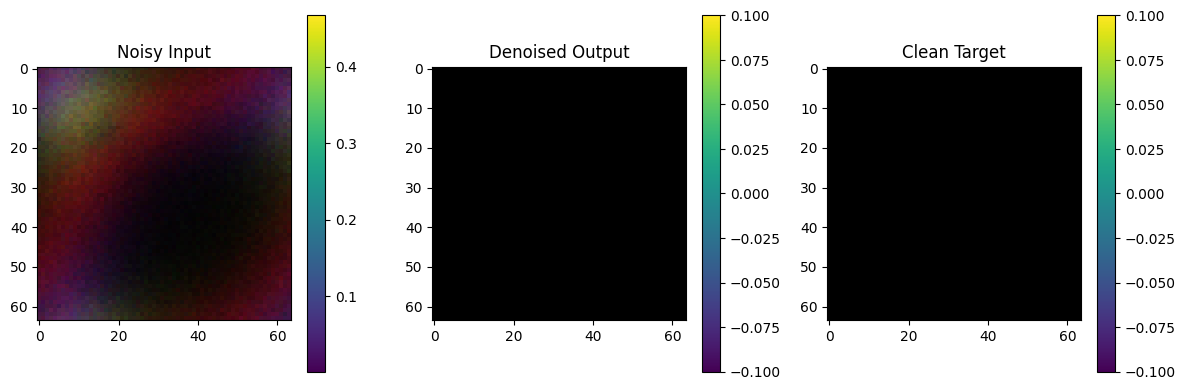

In [10]:
x_train_rgb, x_val_rgb, x_test_rgb, y_train_rgb, y_val_rgb, y_test_rgb = batch_project_3d_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    buffer_scale=1.10
)
#Try learning rate scheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt


def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
    print(total)
    return x / (total + 1e-8) * 8.0

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# --- 3D CAE Model Definition ---
def create_simple_2d_cae(input_shape=(64, 64, 3), dropout_rate=0.2, l2_strength=1e-8):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)


    output_layer =  layers.Conv2D(3, (3, 3),  activation='relu', padding='same')(x)

    #output_layer = layers.Lambda(renormalize_sum_to_eight)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)




# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)

    input_shape = (64, 64, 3)
    cae = create_simple_2d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train_rgb, y_train_rgb,
        validation_data=(x_val_rgb, y_val_rgb),
        epochs=5,
        batch_size=32,
        callbacks=callbacks_list,
        verbose=1)

    # Predict one test volume
    i = 0
    denoised = cae.predict(x_test_rgb[i:i+1])[0]
    noisy_input = x_test_rgb[i]
    true_clean = y_test_rgb[i]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input)
    plt.title("Noisy Input")
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(denoised)
    plt.title("Denoised Output")
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(true_clean)
    plt.title("Clean Target")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()



In [44]:
# --- Evaluation on the Test Set ---
print(">>> Testing on the projected RGB test set")
print(x_test_rgb.shape, "Shape of test set")

# Average prediction (mean image)
test_avg = np.mean(x_test_rgb, axis=0)
print(test_avg.shape, "Shape of average of test set")
ref_d = y_test_rgb[0]  # Choose a representative DFT reference
print(ref_d.shape, "Reference shape (should be (64, 64, 3))")

# --- 2-Norm Difference ---
print("2-norm difference")
print("Mean vs DFT 2-norm diff:")
print(np.linalg.norm(test_avg - ref_d))

# --- Prediction vs Reference ---
print("\nPrediction of one test sample vs DFT")
print(x_test_rgb[0:1].shape, "Test sample shape")

# Predict denoised image
pred = cae.predict(x_test_rgb[0:1])[0]
print(pred.shape, "Prediction shape", ref_d.shape)
print("2-norm(pred vs DFT):", np.linalg.norm(pred - ref_d))

# --- Jensen-Shannon Divergence Analysis ---
print("\nDivergence differences")

# Predict mean of test set passed through model
mean_pred = cae.predict(test_avg.reshape(1, 64, 64, 3))[0]

print("JSD(bar{x_test}, y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d.copy()).numpy())
print("JSD(DAE(bar{x}), y_dft):", jensen_shannon_divergence_loss(mean_pred, ref_d.copy()).numpy())
print("JSD(DAE(x_i), y_dft):", jensen_shannon_divergence_loss(pred, ref_d.copy()).numpy())


>>> Testing on the projected RGB test set
(500, 64, 64, 3) Shape of test set
(64, 64, 3) Shape of average of test set
(64, 64, 3) Reference shape (should be (64, 64, 3))
2-norm difference
Mean vs DFT 2-norm diff:
0.5687976996472337

Prediction of one test sample vs DFT
(1, 64, 64, 3) Test sample shape
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
(64, 64, 3) Prediction shape (64, 64, 3)
2-norm(pred vs DFT): 0.7915059166657622

Divergence differences
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
JSD(bar{x_test}, y_dft): 0.00022791175
JSD(DAE(bar{x}), y_dft): 0.0004112618
JSD(DAE(x_i), y_dft): 0.00035534744


In [45]:
def normalize_to_electron_count(x, target_sum=8.0):
    # Avoid division by zero
    current_sum = np.sum(x, axis=(1, 2, 3), keepdims=True)
    current_sum[current_sum == 0] = 1.0
    return x * (target_sum / current_sum)

# Normalize test set and reference to have total sum = 8
x_test_norm = normalize_to_electron_count(x_test_rgb.copy(), target_sum=8.0)
ref_d_norm = ref_d.copy() * (8.0 / np.sum(ref_d))

# --- Average prediction (mean image) ---
test_avg = np.mean(x_test_norm, axis=0)
print("Shape of test set:", x_test_norm.shape)
print("Shape of average of test set:", test_avg.shape)
print("Shape of reference:", ref_d_norm.shape)

# --- 2-Norm Difference ---
print("\n2-norm difference")
print("Mean vs DFT 2-norm diff:", np.linalg.norm(test_avg - ref_d_norm))

# --- Prediction vs Reference ---
print("\nPrediction of one test sample vs DFT")
pred = cae.predict(x_test_norm[0:1])[0]
print("Prediction shape:", pred.shape)

# Normalize prediction
pred_norm = pred * (8.0 / np.sum(pred))

print("2-norm(pred, ref_d):", np.linalg.norm(pred_norm - ref_d_norm))

# --- Jensen-Shannon Divergence Analysis ---
print("\nJensen-Shannon Divergence")

mean_pred = cae.predict(test_avg.reshape(1, 64, 64, 3))[0]
mean_pred_norm = mean_pred * (8.0 / np.sum(mean_pred))

print("JSD(bar{x_test}, y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d_norm).numpy())
print("JSD(DAE(bar{x}), y_dft):", jensen_shannon_divergence_loss(mean_pred_norm, ref_d_norm).numpy())
print("JSD(DAE(x_i), y_dft):", jensen_shannon_divergence_loss(pred_norm, ref_d_norm).numpy())


Shape of test set: (500, 64, 64, 3)
Shape of average of test set: (64, 64, 3)
Shape of reference: (64, 64, 3)

2-norm difference
Mean vs DFT 2-norm diff: 0.0028275657677668147

Prediction of one test sample vs DFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Prediction shape: (64, 64, 3)
2-norm(pred, ref_d): 0.06067912519128907

Jensen-Shannon Divergence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
JSD(bar{x_test}, y_dft): 0.00022791178
JSD(DAE(bar{x}), y_dft): 0.06483744
JSD(DAE(x_i), y_dft): 0.06484163
